<div class="alert alert-info">
**Note:**

You can download this demo as a Jupyter notebook [here](https://github.com/ejhigson/dyPolyChord/blob/master/docs/demo.ipynb) and run it interactively yourself.
</div>

# dyPolyChord Demo

The main user-facing function is ``dyPolyChord.run_dypolychord``, which performs dynamic nested sampling.

Likelihoods and priors are specified as a python callable, which can be used to run PolyChord on the likelihood and prior with an input settings dictionary. Tools for making such a callable are provided in ``pypolychord_utils.py`` (python likelihoods and priors) and ``polychord_utils.py`` (compiled C++ and Fortran likelihoods and priors).

In addition the user can specify PolyChord settings (as a dictionary), and can choose whether to prioritise parameter estimation or evidence calculation via the ``dynamic_goal`` argument (see the [dynamic nested sampling paper](https://arxiv.org/abs/1704.03459) for an explanation).

## Compiled (C++ or Fortran) likelihoods and priors

C++ and Fortran likelihoods used by PolyChord can also be used by ``dyPolyChord`` (they must be able to read settings from .ini files). These must be compiled to executables within the PolyChord directory, via commands such as

    $ make gaussain  # PolyChord gaussian example

or

    $ make polychord_CC_ini  # PolyChord template C++ likelihood which reads .ini file

See the PolyChord README for more details. ``dyPolyChord`` simply needs the file path to the executable, which it runs via ``os.system`` - settings are specified by writing temporary .ini files.

In [ ]:
import dyPolyChord.polychord_utils
import dyPolyChord


# Definte the distribution to sample (likelihood, prior, number of dimensions)
ex_command = './gaussian'  # path to compiled executable likelihood
# The prior must be specified as strings via .ini files. get_prior_block_str provides a
# convenient function for making such PolyChord-formatted strings. See its docstring and
# the PolyChord documentation for more details
ndim = 10
prior_str = dyPolyChord.polychord_utils.get_prior_block_str(
    'gaussian',  # name of prior - see PolyChord for a list of allowed priors
    [0.0, 10.0],  # parameters of the prior
    ndim)

# Make a callable for running PolyChord
my_callable = dyPolyChord.polychord_utils.RunCompiledPolyChord(
    ex_command, prior_str)

# Specify sampler settings (see run_dynamic_ns.py documentation for more details)
dynamic_goal = 1.0  # whether to maximise parameter estimation or evidence accuracy. 
ninit = 100          # number of live points to use in initial exploratory run.
nlive_const = 500   # total computational budget is the same as standard nested sampling with nlive_const live points. 
settings_dict = {'file_root': 'gaussian',
                 'base_dir': 'chains',
                 'seed': 1}

# Run dyPolyChord
dyPolyChord.run_dypolychord(my_callable, dynamic_goal, settings_dict,
                            ninit=ninit, nlive_const=nlive_const)

## Python likelihoods and priors

Python likelihoods and priors must be defined as functions or callable classes, just as for running PyPolyChord (PolyChord's python wrapper). Otherwise the process is very similar to that with compiled likelihoods.

In [ ]:
import dyPolyChord.python_likelihoods as likelihoods  # Import some example python likelihoods
import dyPolyChord.python_priors as priors  # Import some example python priors
import dyPolyChord.pypolychord_utils
import dyPolyChord


# Definte the distribution to sample (likelihood, prior, number of dimensions)
ndim = 10
likelihood = likelihoods.Gaussian(sigma=1.0)
prior = priors.Gaussian(sigma=10.0)

# Make a callable for running PolyChord
my_callable = dyPolyChord.pypolychord_utils.RunPyPolyChord(
    likelihood, prior, ndim)

# Specify sampler settings (see run_dynamic_ns.py documentation for more details)
dynamic_goal = 1.0  # whether to maximise parameter estimation or evidence accuracy. 
ninit = 100          # number of live points to use in initial exploratory run.
nlive_const = 500   # total computational budget is the same as standard nested sampling with nlive_const live points. 
settings_dict = {'file_root': 'gaussian',
                 'base_dir': 'chains',
                 'seed': 1}

# Run dyPolyChord
dyPolyChord.run_dypolychord(my_callable, dynamic_goal, settings_dict,
                            ninit=ninit, nlive_const=nlive_const)

## Parallelisation


#### Compiled likelihoods and priors

To run compiled likelihoods in parallel with MPI, specify an mpirun command in the `mpi_str` argument when initializing your `RunPyPolyChord` object. For example to run with 8 processes, use

In [ ]:
my_callable = dyPolyChord.polychord_utils.RunCompiledPolyChord(
    ex_command, prior_str, mpi_str='mpirun -np 8')

The callable can then be used with `run_dypolychord` as normal.

#### Python likelihoods and priors

You must import `mpi4py`, create an `MPI.COMM_WORLD` object and pass it to `run_dypolychord` as an argument.

In [ ]:
from mpi4py import MPI
comm = MPI.COMM_WORLD

dyPolyChord.run_dypolychord(my_callable, dynamic_goal, settings_dict,
                            ninit=ninit, nlive_const=nlive_const, comm=comm)

You can then run your script with mpirun:

    $ mpirun -np 8 my_dypolychord_script.py

#### Repeated runs

If you want to perform a number of independent `dyPolyChord` calculations (such as repeating the same calculation many times) then, as this is "embarrassingly parallel", you don't need MPI and can instead perform many `dyPolyChord` runs in parallel using python's `concurrent.futures`. This also allows reliable random seeding for reproducible results, which is not possible with MPI due to the unpredictable order in which slave processes are called by PolyChord. Note that for this to work PolyChord must be installed without MPI.

For an example of this type of usage, see the code used to make the results for the dynamic nested sampling paper (https://github.com/ejhigson/dns).

## Checking the output

Running ``dyPolyChord`` produces PolyChord-format output files in `settings['base_dir']`. These output files can be analysed in the same way as other PolyChord output files.

One convenient package for doing this in python is ``nestcheck`` (http://nestcheck.readthedocs.io/en/latest/). We can use it to load and analyse the results from the 10-dimensional Gaussian produced by running the second cell in this demo (the example python likelihood and prior).

In [1]:
import nestcheck.data_processing
import nestcheck.estimators as e

# load the run
run = nestcheck.data_processing.process_polychord_run(
    'gaussian',  # = settings['file_root']
    'chains')    # = settings['base_dir']

print('The log evidence estimate using the first run is {}'
      .format(e.logz(run)))
print('The estimateed the mean of the first parameter is {}'
      .format(e.param_mean(run, param_ind=0)))

The log evidence estimate using the first run is -31.97320739404335
The estimateed the mean of the first parameter is -0.009077055705321546


As an illustration, lets use ``nestcheck`` to check ``dyPolyChord``'s allocation of live points roughly matches the distribution of posterior mass, which it should do when the dynamic goal setting equals 1. For a detailed explanation of this type of plot, see Figure 4 in the dynamic nested sampling paper ([Higson et al., 2017](https://arxiv.org/abs/1704.03459)) and its caption.

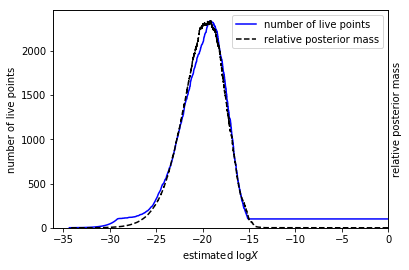

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nestcheck.ns_run_utils
%matplotlib inline

# get the sample's estimated logX co-ordinates and relative posterior mass
logx = nestcheck.ns_run_utils.get_logx(run['nlive_array'])
logw = logx + run['logl']
w_rel = np.exp(logw - logw.max())

# plot nlive and w_rel on same axis
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
l1 = ax1.plot(logx, run['nlive_array'], label='number of live points', color='blue')
l2 = ax2.plot(logx, w_rel, label='relative posterior mass', color='black', linestyle='dashed')
lines = l1 + l2
ax1.legend(lines, [l.get_label() for l in lines], loc=0)
ax1.set_xlabel('estimated $\log X$')
ax1.set_xlim(right=0.0)
ax1.set_ylim(bottom=0.0)
ax1.set_ylabel('number of live points')
ax2.set_ylim(bottom=0.0)
ax2.set_yticks([])
ax2.set_ylabel('relative posterior mass')
plt.show()

It looks like `dyPolyChord`'s allocation of samples closely matches the regions with high posterior mass, as expected.

Note that this plot is only approximate as the $\log X$ values ($x$ coordinates) are estimated from just the one run, and are correlated with the posterior mass estimates. For a more accurate version, see Figure 4 of [Higson et al., (2017)](https://arxiv.org/abs/1704.03459).